<a href="https://colab.research.google.com/github/500081/M7DataSP/blob/main/cv03_domaci_ukol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.8 MB/s eta 0:00:00


In [2]:
import timm
import os

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

from fastai.vision.all import *

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Our custom dataset - 10 Monkey Species

https://www.kaggle.com/datasets/slothkong/10-monkey-species

---



In [7]:
DATASET = 'slothkong/10-monkey-species'
ZIP_PATH = './10-monkey-species.zip'
IMAGES_PATH = './training/training'

In [8]:
os.environ['KAGGLE_USERNAME'] = 'evaklimentov'
os.environ['KAGGLE_KEY'] = 'c3161c890c8b21e1e5cba18c9a7505c0'

!kaggle datasets download -d {DATASET} -p ./

100% 547M/547M [00:26<00:00, 23.9MB/s]
100% 547M/547M [00:26<00:00, 22.0MB/s]


In [9]:
import zipfile

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('./')

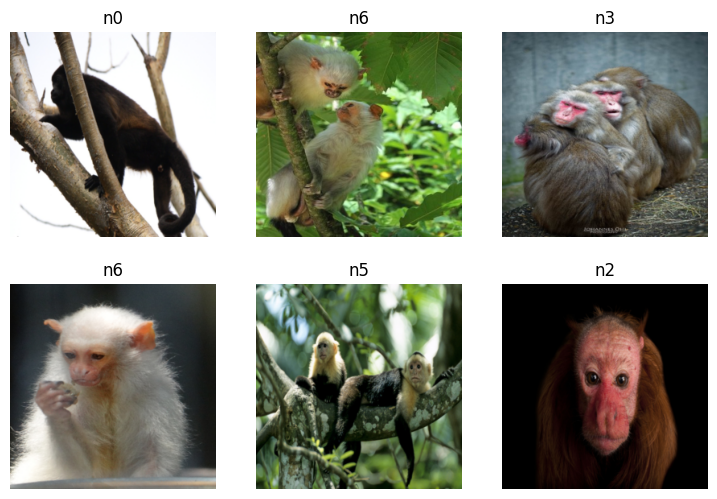

In [10]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256, method='squish'))

dls = images.dataloaders(IMAGES_PATH, bs=64)

dls.show_batch(max_n=6)

In [11]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))

878
219


## Load ConvNeXt model and fine-tune it

In [12]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(3, freeze_epochs=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:06<00:00, 18.7MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.015163,0.676306,0.858447,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.159168,0.155094,0.963470,00:45
1,0.099418,0.027801,0.995434,00:46
2,0.068652,0.011576,0.995434,00:44


## See how our model performs:


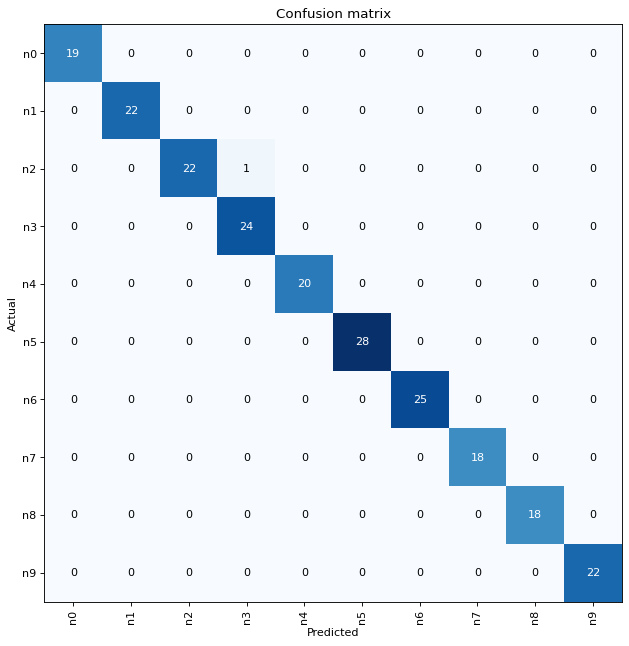

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

### what is hard to predic?

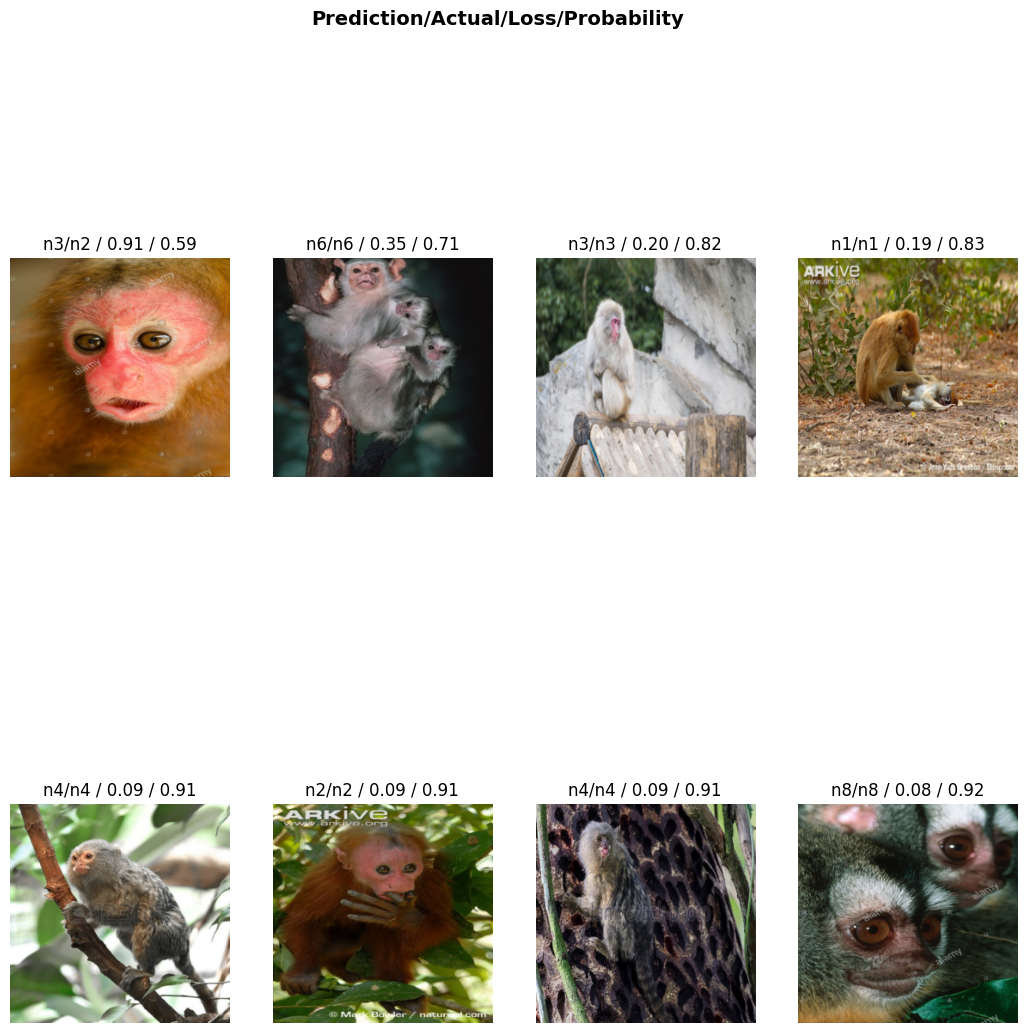

In [14]:
interp.plot_top_losses(8, figsize=(13,13))

## Data augmentation

use image transformations from https://docs.fast.ai/vision.augment.html

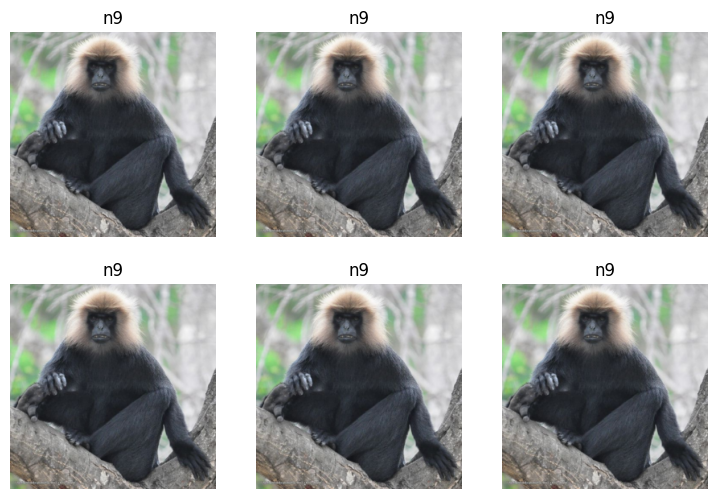

In [16]:
tfms = [DeterministicFlip(), RandomErasing()]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=tfms
).dataloaders(IMAGES_PATH, bs=64)

dls.show_batch(max_n=6, unique=True)

In [17]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(3, freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,time
0,2.044280,0.695403,0.858447,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.314191,0.188206,0.958904,00:46
1,0.205887,0.048027,0.990868,00:47
2,0.169672,0.030500,0.990868,00:51
